In [46]:
import sys
import os

import numpy as np
from scipy import io

import matplotlib.pyplot as plt
%matplotlib inline

import cvxpy

In [47]:
numTrain = 500

mat_dict = io.loadmat('portfolio.mat')

train_cl = mat_dict['train_cl'][:numTrain]
train_hi = mat_dict['train_hi'][:numTrain]
train_lo = mat_dict['train_lo'][:numTrain]
train_op = mat_dict['train_op'][:numTrain]
train_vol = mat_dict['train_vol'][:numTrain]
train_cl = train_cl.T
train_op = train_op.T

test_cl = mat_dict['train_cl'][numTrain:]
test_hi = mat_dict['train_hi'][numTrain:]
test_lo = mat_dict['train_lo'][numTrain:]
test_op = mat_dict['train_op'][numTrain:]
test_vol = mat_dict['train_vol'][numTrain:]
numDays, numStocks = test_cl.shape

all_stocks = []
for i in range(numStocks):
    all_stocks.append(np.array_str(mat_dict['train_stocks'][0][i])[3:-2])

In [48]:
def uniform_rebalance(t, portfolio_t, hi, lo, cl, op, stocks, vol):
    """% Input: 
    %%% t: we are at Day t
    %%% portfolio_t: current portfolio before open of Day t
    %%% hi: highest prices at Day t-1
    %%% lo: lowest prices at Day t-1
    %%% cl: close prices at Day t-1
    %%% op: open prices at Day t
    %%% stocks: names of all stocks
    %%% vol: volumes at Day t-1

    % Output: 
    %%% portfolio: a column vector, each entry represents the portion of 
    %%%            the value of the corresponding stock over the total cash 
    %%%            realizable value [as a result, the value of inactive stocks 
    %%%            i.e., with open price NaN, cannot be added into the total
    %%%            cash realizable value]. Hence, your output must satisfy
    %%%            sum(portfolio(isfinite(op))) < 1, and the rest is the 
    %%%            portion of cash realizable value you hold in cash. 
    %%% hold_flag: a binary vector representing whether you would like to hold
    %%%            (with value 1) each stock or you choose to rebalance it
    %%%            (with value 0). """
    
    numStocks = len(stocks)
    portfolio = np.zeros(numStocks)
    numActiveStock = np.sum(np.isfinite(op))
    portfolio[np.isfinite(op)] = 1.0/numActiveStock
        
    if np.mod(t,2) == 1:
        hold_flag = np.zeros(numStocks,dtype=bool)
    else:
        hold_flag = np.ones(numStocks,dtype=bool)      
    return portfolio, hold_flag

In [49]:
# params
window_size = 450
mu = 1e-1
eta = 1e-1

# initialize initial p matrix
p_init = np.zeros([numStocks, numTrain])

# build initial p matrix
for curr_t in range(1, numTrain):
        
    nan_locs = np.where(np.logical_or(np.isnan(train_cl[:, curr_t-1]),
               np.isnan(train_cl[:, curr_t])))[0]
    non_nan_locs = np.where(np.logical_and(np.isfinite(train_cl[:, curr_t-1]),
                   np.isfinite(train_cl[:, curr_t])))[0]
        
    p_init[nan_locs, curr_t] = 0
    p_init[non_nan_locs, curr_t] = (train_cl[non_nan_locs, curr_t]
        - train_cl[non_nan_locs, curr_t-1]) / train_cl[non_nan_locs, curr_t-1]
    
# matrices to save data
cls = np.zeros([numStocks, numDays])
ops = np.zeros([numStocks, numDays])

def windowitz(t, portfolio_t, hi, lo, cl, op, stocks, vol):
    
    # save data
    cls[:, t] = cl.T
    ops[:, t] = op.T
    
    if t % 90 is 0:
    
        # initialize p matrix
        p = np.zeros([numStocks, t])
    
        # build p matrix
        for curr_t in range(1, t):
            nan_locs = np.where(np.logical_or(np.isnan(cls[:, curr_t-1]),
                       np.isnan(cls[:, curr_t])))[0]
            non_nan_locs = np.where(np.logical_and(np.isfinite(cls[:, curr_t-1]),
                           np.isfinite(cls[:, curr_t])))[0]
        
            p[nan_locs, curr_t] = 0
            p[non_nan_locs, curr_t] = (cls[non_nan_locs, curr_t]
                - cls[non_nan_locs, curr_t-1]) / cls[non_nan_locs, curr_t-1]
        
        # compute statistics
        pbar = np.mean(np.hstack([p_init, p])[:, t+numTrain-window_size:t+numTrain-1], axis=1)
        sigma = np.cov(np.hstack([p_init, p])[:, t+numTrain-window_size:t+numTrain-1])
    
        # set up and solve markowitz problem
        b_opt = cvxpy.Variable(numStocks)
        objective = cvxpy.Minimize(-pbar*b_opt + mu*cvxpy.quad_form(b_opt, sigma + np.eye(numStocks))
                    + eta*cvxpy.pnorm(b_opt - portfolio_t, 2))
        constraints = [cvxpy.sum_entries(b_opt) == 1., b_opt >= -0.5, b_opt <= 0.5]
        problem = cvxpy.Problem(objective, constraints)
        problem.solve(verbose=False, solver='SCS')
                           
        b_opt = b_opt.value
    
        portfolio = np.zeros(numStocks)
        portfolio[np.isfinite(op)] = b_opt[np.isfinite(op)]
        portfolio /= np.sum(portfolio)
    
        return portfolio, np.zeros(numStocks, dtype=bool)
    
    else:
        return portfolio_t, np.ones(numStocks, dtype=bool)

In [50]:
def rebalance(value_vec, value_realizable, portfolio_dst, cost_rate):
    """ % This function simulates the process of rebalancing. The key difficulty 
    % here is to compute the transaction cost, i.e., to solve the equation
    %
    % sum( cost_rate * abs( portfolio_dst .* (value_realizable - C) -
    % value_vec) ) = C
    % 
    % where C is the total transcation cost. We use the Banach contraction 
    % theorem to solve this equation, with convergence rate cost_rate^t for 
    % t-th iteration. 

    % Input: 
    %%% value_vec: current values of each active stock
    %%% value_realizable: total cash realizable value
    %%% portfolio_dst: the desired portfolio after rebalancing
    %%% cost_rate: ratio of transactions cost (0.0005 in our case)

    % Output:
    %%% new_value_vec: the value vector after rebalancing
    %%% trans_cost: the total transaction cost"""
    
    iter_num = 7
    trans_cost = 0
    for iter in range(iter_num):
        trans_cost = np.sum(cost_rate * np.abs(portfolio_dst * \
                        (value_realizable-trans_cost)-value_vec))
        
    new_value_vec = portfolio_dst * (value_realizable - trans_cost)
    return new_value_vec, trans_cost

In [51]:
value_op_seq = np.zeros(numDays) # total value before open of each day
value_cl_seq = np.zeros(numDays) # total value before close of each day 
portfolio_seq = np.zeros((numStocks, numDays)) # portfolio before open of each day
last_close_price = np.NaN * np.ones(numStocks)
print numDays, numStocks

747 497


In [52]:
# Initialization
op = test_op[0,:]
cl = np.NaN * np.ones(numStocks)
hi = np.NaN * np.ones(numStocks)
lo = np.NaN * np.ones(numStocks)
vol = np.NaN * np.ones(numStocks)
value_op_seq[0] = 1 # initially we hvae one unit of cash

In [53]:
for t in range(numDays):
    print t,
    
    # At the beginning of day t, we use all information up to the open 
    # price of day t to determine the capital allocation at the end of 
    # day t.
    
    # Your function should be placed here. Note that the input vector may
    # contain NaNs (at Day 1, or for some inactive stocks). 
    new_portfolio, hold_flag = windowitz(t, portfolio_seq[:,t], hi, lo, cl, op, all_stocks, vol)
    
    # Check whether your output is valid
    isActive = np.isfinite(op)
    noHold = np.logical_and(isActive, np.logical_not(hold_flag))
    if np.sum(new_portfolio[noHold]) > 1 + 1e-8:
        sys.stderr.write('The output portfolio is not valid!')
        
    # The value of our portfolio at the end of Day t before paying transaction costs
    cl = test_cl[t,:]
    value_vec = value_op_seq[t] * portfolio_seq[:,t]
    growth = cl[isActive] / last_close_price[isActive]-1
    growth[np.isnan(growth)] = 0
    revenue_vec = value_vec[isActive] * growth
    value_vec[isActive] = value_vec[isActive] + revenue_vec
    value_cl_seq[t] = value_op_seq[t] + np.sum(revenue_vec)
        

    # At the end of Day t, we use the close price of day t to adjust our 
    # portfolio to the desired percentage.
    if t <= numDays-2:
        nonActive = np.logical_not(isActive)
        value_realizable = value_cl_seq[t] - np.sum(value_vec[nonActive])
        new_value_vec, trans_cost = rebalance(value_vec[isActive], value_realizable, \
                                              new_portfolio[isActive], 0.0005)
        value_op_seq[t+1] = value_cl_seq[t] - trans_cost
        value_vec[isActive] = new_value_vec
        portfolio_seq[:,t+1] = value_vec / value_op_seq[t+1]
        
    last_close_price[isActive] = cl[isActive]
    
    # Update information
    if t <= numDays-2:
        op = test_op[t+1,:]
        hi = test_op[t,:]
        lo = test_lo[t,:]
        vol = test_vol[t,:]

0

/Users/rs/Dropbox/Workspace/portfolio-opt/venv/lib/python2.7/site-packages/ipykernel/__main__.py:62: DeprecationWarning: assignment will raise an error in the future, most likely because your index result shape does not match the value array shape. You can use `arr.flat[index] = values` to keep the old behaviour.


 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 100 101 102 103 104 105 106 107 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215 216 217 218 219 220 221 222 223 224 225 226 227 228 229 230 231 232 233 234 235 236 237 238 239 240 241 242 243 244 245 246 247 248 249 250 251 252 253 254 255 256 257 258 259 260 261 262 263 264 265 266 267 268 269 270 271 272 273 274 275 276 277

0.0981580741602 0.288844707045


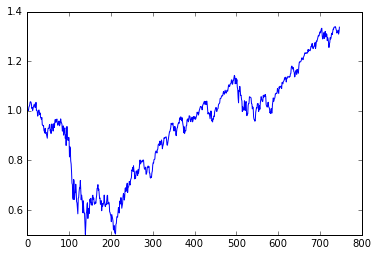

In [54]:
plt.plot(value_op_seq)
return_seq = np.log(value_op_seq[1:] / value_op_seq[:-1])
annual_return = 252 * np.mean(return_seq)
sharpe = np.sqrt(252) * np.mean(return_seq) / np.std(return_seq)
print annual_return, sharpe